**Description**: MNRL requires pretty aggressive de-duplication during batch sampling.
W/o it, the labels would be incorrect. With MPNRL, we can use default batch sampling and
then group anchors in the collator. As a result, batch sizes are much more stable.

TODO:
  - Check that GPU utilization is also more stable by training.
  - Check that training is more stable.
  - Measure how long it takes for MNRL vs MPRNL to get to a good model (pearson/spearman
    correlation on validation data).
  - Repeat for a few datasets and study how the level of data duplication affects these
    outcomes.

In [1]:
from datetime import datetime
from typing import Any

from datasets import load_dataset
import matplotlib.pyplot as plt
import polars as pl
import seaborn as sns
from sentence_transformers import (
    SentenceTransformer,
    SentenceTransformerTrainer,
    SentenceTransformerTrainingArguments,
    losses,
)
from sentence_transformers.training_args import BatchSamplers
from tqdm.auto import tqdm

from mpnrl import (
    MPNRLDataCollator,
    MultiplePositivesNegativesRankingLoss,
)

In [2]:
sns.set_theme(style="darkgrid")

# Load model and data

In [3]:
model_name = "distilroberta-base"

num_train_epochs = 1

# Save path of the model
output_dir = f"output/sigltt_nli_{model_name.replace('/', '-')}-{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}"

In [4]:
# 1. Here we define our SentenceTransformer model. If not already a Sentence Transformer model, it will automatically
# create one with "mean" pooling.
model = SentenceTransformer(model_name)
# If we want, we can limit the maximum sequence length for the model
# model.max_seq_length = 75

No sentence-transformers model found with name distilroberta-base. Creating a new one with mean pooling.
/Users/kdubey/Envs/base/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [5]:
# 2. Load the AllNLI dataset:
#    https://huggingface.co/datasets/sentence-transformers/all-nli
dataset_name = "sentence-transformers/all-nli"
train_dataset = load_dataset(dataset_name, name="triplet", split="train")

# If you wish, you can limit the number of training samples
train_dataset = train_dataset.select(range(10_000))

# Utils

In [6]:
dummy_batch_size = 128

In [7]:
def dry_run(
    trainer: SentenceTransformerTrainer, num_batches_hardcoded: int | None = None
) -> list[dict[str, Any]]:
    if num_batches_hardcoded is None:
        num_batches = len(
            trainer.get_batch_sampler(
                trainer.train_dataset,
                batch_size=trainer.args.train_batch_size,
                drop_last=trainer.args.dataloader_drop_last,
                valid_label_columns=trainer.data_collator.valid_label_columns,
            )
        )
    else:
        num_batches = num_batches_hardcoded

    data = []
    for sentence_features, labels in tqdm(
        map(trainer.collect_features, trainer.get_train_dataloader()), total=num_batches
    ):
        batch_data = {}
        features_anchor, features_candidates = (
            sentence_features[0],
            sentence_features[1:],
        )
        batch_data["num_anchors"] = features_anchor["input_ids"].shape[0]
        batch_data["num_candidates"] = sum(
            features["input_ids"].shape[0] for features in features_candidates
        )
        if labels is not None:
            batch_data["num_positives_per_anchor"] = [
                len(indices) for indices in labels
            ]
        data.append(batch_data)
    return data

In [8]:
def plot(
    batch_data: list[dict[str, Any]], batch_size: int, title: str = ""
) -> plt.Axes:
    # FYI: mostly written by ChatGPT
    df = (
        pl.DataFrame(batch_data)
        .with_columns(pl.Series("batch", range(1, len(batch_data) + 1)))
        .rename({"num_anchors": "anchors", "num_candidates": "candidates"})
    )
    melted_df = df.melt(
        id_vars=["batch"],
        value_vars=["anchors", "candidates"],
        variable_name="Type",
        value_name="Value",
    )
    ax = sns.lineplot(data=melted_df, x="batch", y="Value", hue="Type")
    ax.axhline(y=batch_size, color="k", linestyle="--", label="inputted batch size")
    ax.set_ylabel("# observations")
    ax.set_title(title)
    ax.legend()
    return ax

# MNRL dataloader

In [9]:
dummy_trainer_mnrl = SentenceTransformerTrainer(
    model=model,
    args=SentenceTransformerTrainingArguments(
        # Required parameter:
        output_dir=output_dir,
        # Optional training parameters:
        use_mps_device=False,
        num_train_epochs=1,
        per_device_train_batch_size=dummy_batch_size,
        batch_sampler=BatchSamplers.NO_DUPLICATES,  # MultipleNegativesRankingLoss benefits from no duplicate samples in a batch
        seed=42,
    ),
    train_dataset=train_dataset,
    loss=losses.MultipleNegativesRankingLoss(model),
    data_collator=None,
)

In [10]:
batch_data_mnrl = dry_run(dummy_trainer_mnrl, num_batches_hardcoded=3138)

  0%|          | 0/3138 [00:00<?, ?it/s]

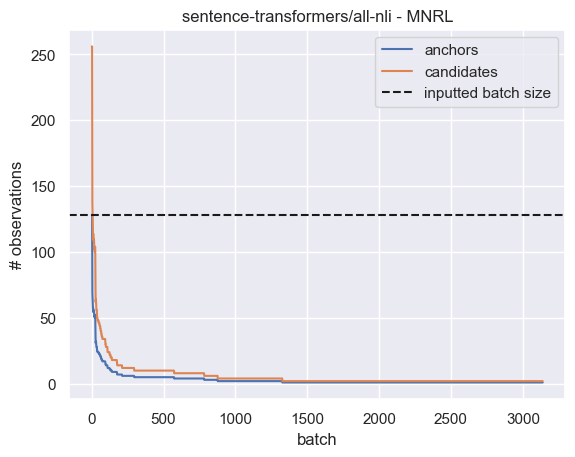

In [11]:
ax_mnrl = plot(batch_data_mnrl, dummy_batch_size, title=f"{dataset_name} - MNRL")

# MPNRL dataloader

In [12]:
dummy_trainer_mpnrl = SentenceTransformerTrainer(
    model=model,
    args=SentenceTransformerTrainingArguments(
        # Required parameter:
        output_dir=output_dir,
        # Optional training parameters:
        use_mps_device=False,
        num_train_epochs=1,
        per_device_train_batch_size=dummy_batch_size,
        batch_sampler=BatchSamplers.BATCH_SAMPLER,
        seed=42,
    ),
    train_dataset=train_dataset,
    loss=MultiplePositivesNegativesRankingLoss(model),
    data_collator=MPNRLDataCollator(train_dataset, tokenize_fn=model.tokenize),
)

In [13]:
batch_data_mpnrl = dry_run(dummy_trainer_mpnrl)

  0%|          | 0/79 [00:00<?, ?it/s]

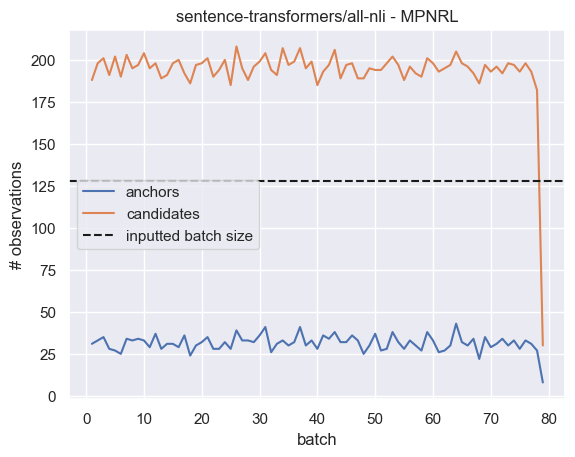

In [14]:
ax_mpnrl = plot(batch_data_mpnrl, dummy_batch_size, title=f"{dataset_name} - MPNRL")